# Project 4 - Gamma-ray Astronomy

This notebook contains the associated code used to analyze the gamma-ray data set and produce the plots shown in the associated project write up. All answers to the questions asked in the project outline are answered in the project ***.pdf*** writeup. This notebook is only used for analysis and plotting. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits 
from astropy.coordinates import SkyCoord 
from concurrent.futures import ProcessPoolExecutor, as_completed


#importing custom made matplotlib rcParams plot settings
from fancy_plotting import *
fancy_plotting(use_tex=True)  #plot using latex style fonts

## Data Exploration

Beginning with loading in the gamma-ray fits file, we can inspect the file and plot the ra and dec of events.

In [2]:
fits_file = "gammaray.fits"
gray_fits = fits.open(fits_file)
gray_fits.info()

Filename: gammaray.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     16   96498R x 4C   [D, D, D, D]   


In [3]:
#the gamma ray data is in the #1 row of the fits file
gammaray_data = gray_fits[1].data

In [4]:
#inspect the data header to better view what we're working with
gray_fits[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                96498 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'RA(rad) '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'Dec(rad)'                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'mscl    '        

Can also examine the columns this way

In [ ]:
#looking for location of RA and DEC columns
gammaray_data.columns

ColDefs(
    name = 'RA(rad)'; format = 'D'
    name = 'Dec(rad)'; format = 'D'
    name = 'mscl'; format = 'D'
    name = 'mscw'; format = 'D'
)

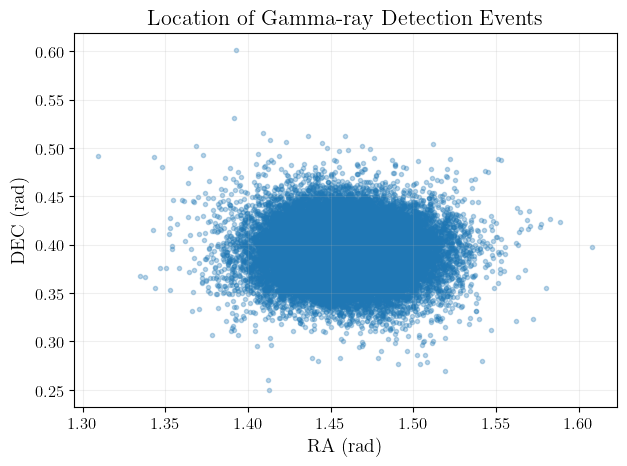

In [6]:
#using the output above, plot the events
RA_list = gammaray_data['RA(rad)']
DEC_list = gammaray_data['Dec(rad)']

plt.scatter(RA_list, DEC_list, alpha=0.3, lw=1, marker='.')
plt.title('Location of Gamma-ray Detection Events')
plt.xlabel('RA (rad)')
plt.ylabel('DEC (rad)')
plt.grid(alpha=0.2)
plt.savefig('plots/events_scatter_ra_dec.png', dpi = 600, bbox_inches='tight')
plt.show()

### Re-plotting as a 2D histogram

Re-plotting things this way sees to provide a bit of a different insight into the statistical distribution of events. 

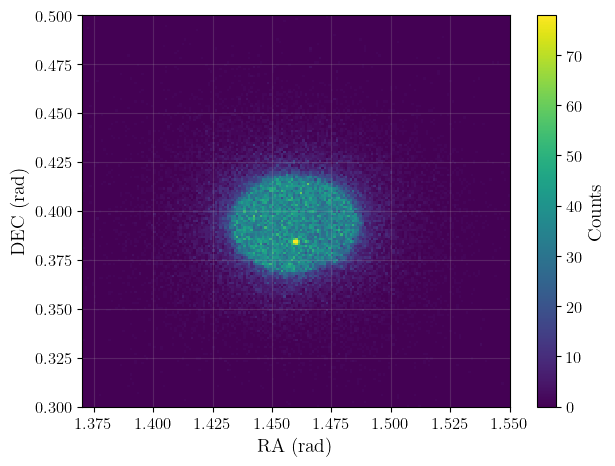

In [7]:
fig = plt.hist2d(RA_list, DEC_list, bins=300, vmax = None)
# plt.title('Histogram of Gamma-ray Detection Events')
plt.xlabel('RA (rad)')
plt.ylabel('DEC (rad)')
plt.xlim(1.37, 1.55)
plt.ylim(0.3, 0.5)
plt.grid(alpha=0.2)
cb = plt.colorbar()
cb.set_label(label='Counts')
plt.savefig('plots/events_hist2d_ra_dec.png', dpi = 600, bbox_inches='tight')
plt.show()

### 3D visualization of the 2D histogram

Creating a 3D visualization of the above plot helps to make certain features like the single bright collection of source events among the larger collection of background events more evident.

In [8]:
hist, xedges, yedges = np.histogram2d(RA_list, DEC_list, bins = 300)

#compute the bin centers from the edges
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters, indexing='ij')

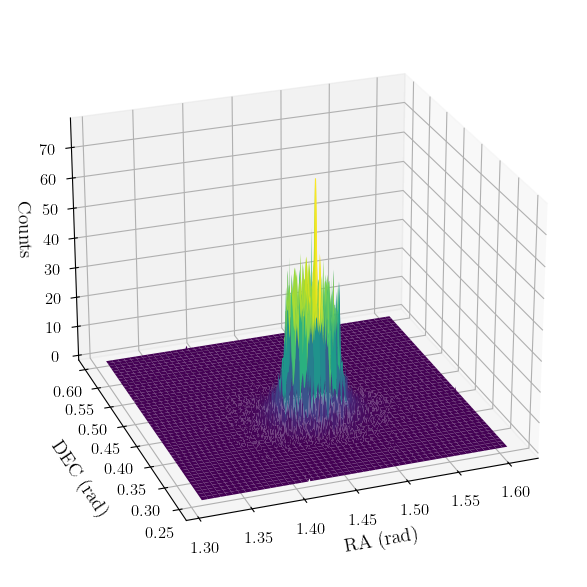

In [9]:
#Plot the 3D surface of the histogram data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, hist, cmap='viridis')
ax.set_xlabel('RA (rad)', labelpad=5)
ax.set_ylabel('DEC (rad)', labelpad=10)
ax.set_zlabel('Counts', )
ax.view_init(elev=25, azim=250)
plt.savefig('plots/events_hist2d_surface_ra_dec.png', dpi = 600, bbox_inches='tight')

# ax.set_title("3D Surface Plot of RA vs DEC Histogram")
plt.show()

### Using "hotspot" location to identify source

In [10]:
#convert the RA and DECs to units of degrees to compare with gamma-sky
#The middles are somewhere around:
RA_mid = 1.46*180/np.pi
DEC_mid = 0.4*180/np.pi
print(f"RA_mid: {RA_mid} deg, DEC_mid: {DEC_mid} deg")

RA_mid: 83.6518380891002 deg, DEC_mid: 22.91831180523293 deg


Using gamma-sky(http://gamma-sky.net/), the source was found to be the following (ie. the well known Crab pulsar):

***Basic Info*** \
Common name: Crab pulsar \
Gamma names: \
Fermi names: \
Other names: PSR 0531+21, V* CM Tau \
Location: gal \
Class: psr \
TeVCat name: TeV J0534+220p (TeVCat ID: 129, TeVCat2 ID: 06r8mb) \
TGeVCat name: (ID: -9223372036854776000) \
Discoverer: magic \
Discovery date: 2008-11 \
Seen by: magic, veritas \
Reference:

***Position Info*** \
SIMBAD 

RA: 83.633 deg \
DEC: 22.014 deg \
GLON: 184.557 deg \
GLAT: -5.784 deg

### Offset calculation

In [11]:
import astropy.units as u

# pointings
RA_pointing, DEC_pointing = 83.6329, 22.5258

#crab pulsar ra and dec (deg)
RA_crab, DEC_crab = 83.633, 22.014

#calculating offsets
RA_offset, DEC_offset = RA_pointing - RA_crab, DEC_pointing - DEC_crab

#create SkyCoord object of the Crab pulsar
c = SkyCoord(ra = RA_crab*u.degree, dec = DEC_crab*u.degree)

print(f"Offsets are: {RA_offset:.5f} deg RA, {DEC_offset:.5f} deg in DEC.\n"
      f"and the coords of the Crab pulsar (our object) are: RA = {c.ra}, DEC = {c.dec}"
      )

Offsets are: -0.00010 deg RA, 0.51180 deg in DEC.
and the coords of the Crab pulsar (our object) are: RA = 83.633 deg, DEC = 22.014 deg


The offset in the RA dimension is small and so this is the one we will take as zero throughout the rest of the project.

## Statistical Detection

### Separation Function

Begin by defining the function to count the number of events within a 0.1 degree region away from a particular RA and DEC. 

In [97]:
def process_chunk(reference_point, ra_chunk, dec_chunk):
    """Helper function to calculate the number of events in a chunk."""
    count = 0
    for ra, dec in zip(ra_chunk, dec_chunk):
        event = SkyCoord(ra=ra, dec=dec, unit="rad")
        sep = event.separation(reference_point)
        if sep.deg < 0.1:
            count += 1
    return count

def sum_events(reference_point, ra_list, dec_list, num_workers=10):
    """
    Counts the number of events that are less than 0.1 degrees away from a given reference point.

    Parameters:
    -----------
    reference_point : `~astropy.coordinates.SkyCoord`
        The sky position of the reference point, represented as a SkyCoord object with 
        right ascension (RA) and declination (DEC) in degrees

    ra_list : list of float
        A list of right ascension values (in radians) for the events to be checked

    dec_list : list of float
        A list of declination values (in radians) for the events to be checked

    num_workers : int, optional
        The number of parallel workers to use. Max seems to be 22 given my pc specs

    Returns:
    --------
    count : int
        The number of events whose separation from the reference point is less than 0.1 degrees

    Notes:
    ------
    This function calculates the separation between each event (represented by 
    its RA and DEC coordinates) and the reference point. If the separation is less 
    than 0.1 degrees, the event is counted. The RA and DEC of the events are 
    expected to be in radians, while the reference point is provided in degrees.
    """
    
    #split the RA and DEC lists into chunks for parallel processing
    chunk_size = len(ra_list) // num_workers
    ra_chunks = [ra_list[i:i + chunk_size] for i in range(0, len(ra_list), chunk_size)]
    dec_chunks = [dec_list[i:i + chunk_size] for i in range(0, len(dec_list), chunk_size)]
    
    total_count = 0

    #use ProcessPoolExecutor to parallelize the computation
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for ra_chunk, dec_chunk in zip(ra_chunks, dec_chunks):
            futures.append(executor.submit(process_chunk, reference_point, ra_chunk, dec_chunk))
        
        #collect results as they are completed
        for future in as_completed(futures):
            total_count += future.result()
    
    return total_count


In [14]:
#check for number of cpu cores available for parallel processing
import os

num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 22


### "On" Events

In [15]:
RA_list = gammaray_data['RA(rad)']
DEC_list = gammaray_data['Dec(rad)']

Investigating effects of counting events using a trimmed version of the total RA and DEC lists.

In [16]:
print(RA_list.shape)
print(len(RA_list)//3)

l_ra_ind = int(len(RA_list)/4)
r_ra_ind = len(RA_list) - int(len(RA_list)/4) 
l_dec_ind = int(len(DEC_list)/4)
r_dec_ind = len(DEC_list) - int(len(DEC_list)/4) 

print(l_ra_ind)
print(r_ra_ind)
print(l_dec_ind)
print(r_dec_ind)

RA_list_trimmed = RA_list[l_ra_ind:r_ra_ind]
DEC_list_trimmed = DEC_list[l_dec_ind:r_dec_ind]

print(len(RA_list_trimmed))

print(RA_list[l_ra_ind])

(96498,)
32166
24124
72374
24124
72374
48250
1.43276047706604


In [17]:
#first create a SkyCoord object for the crab pulsar
source_pos = SkyCoord(ra = RA_crab, dec = DEC_crab, unit = 'deg')

on_events = sum_events(reference_point=source_pos, ra_list=RA_list_trimmed, dec_list=DEC_list_trimmed)
print(on_events)

275


The result leads to less compute time, but seems to undercount compared to the full set.

Using the full RA and DEC data sets..

In [18]:
#first create a SkyCoord object for the crab pulsar
source_pos = SkyCoord(ra = RA_crab, dec = DEC_crab, unit = 'deg')

#find the number of events within 0.1 degree of the crab pulsar
on_events = sum_events(reference_point=source_pos, ra_list=RA_list, dec_list=DEC_list)
print(on_events)

566


### "Off Events"

To create these we can use the offsets calculated above. We said that $\text{RA}_\text{Offset}$ = 0 deg and $\text{DEC}_\text{Offset}$ = 0.5118 deg. Therefore, so that the 3 "off" regions are within the same distance from the telescope pointing as the source position (the Crab pulsar), the regions must be at locations relative to the telescope pointing (obs_pointing) of:

- r1: 
    - RA = obs_pointing_ra - $\text{DEC}_\text{Offset}$ 
    - DEC = obs_pointing_dec
- r2: 
    - RA = obs_pointing_ra + $\text{DEC}_\text{Offset}$
    - DEC = obs_pointing_dec
- r3: 
    - RA = obs_pointing_ra
    - DEC = obs_pointing_dec + $\text{DEC}_\text{Offset}$

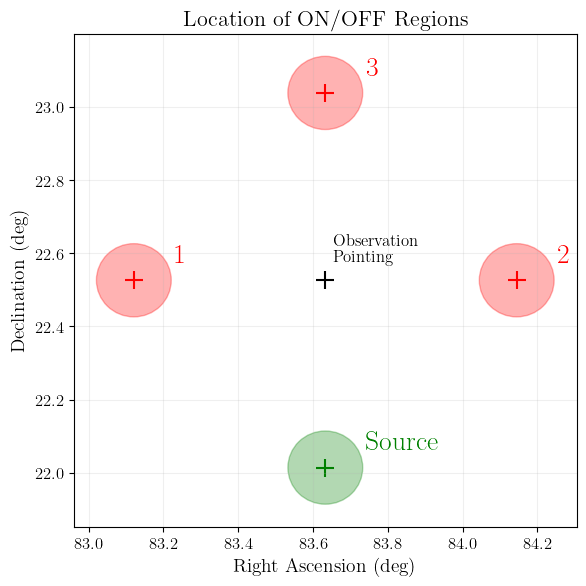

In [83]:
DEC_offset = 0.5118 #rounding here to prevent floating point errors

#define the other three regions (our "off" regions)
r1 = SkyCoord(ra = RA_pointing - DEC_offset, dec = DEC_pointing, unit = "deg")
r2 = SkyCoord(ra = RA_pointing + DEC_offset, dec = DEC_pointing, unit = "deg")
r3 = SkyCoord(ra = RA_pointing, dec = DEC_pointing + DEC_offset, unit = "deg")

#perform sanity check that the new "off" regions are where they're supposed to be
r1_coords = (r1.ra.deg, r1.dec.deg)
r2_coords = (r2.ra.deg, r2.dec.deg)
r3_coords = (r3.ra.deg, r3.dec.deg)
source_coords = (source_pos.ra.deg, source_pos.dec.deg)

ras = np.array([r1_coords[0], r3_coords[0], r2_coords[0]])
decs = np.array([r1_coords[1], r3_coords[1], r2_coords[1]])

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(ras, decs, marker='+', s=150, color='red')
ax.scatter(source_coords[0], source_coords[1], marker='+', s=150, color='green')
ax.scatter(RA_pointing, DEC_pointing, marker='+', s=150, color='black')
ax.set_title("Location of ON/OFF Regions")
ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)')

circ1 = plt.Circle((r1_coords), 0.1, color = 'red', fill=True, alpha = 0.3)
circ2 = plt.Circle((r2_coords), 0.1, color = 'red', fill=True, alpha = 0.3)
circ3 = plt.Circle((r3_coords), 0.1, color = 'red', fill=True, alpha = 0.3)
circ4 = plt.Circle((source_coords), 0.1, color = 'green', fill=True, alpha = 0.3)

ax.text(r1_coords[0]+0.11, r1_coords[1]+0.05, "1", color='red', fontsize='20')
ax.text(r2_coords[0]+0.11, r2_coords[1]+0.05, "2", color='red', fontsize='20')
ax.text(r3_coords[0]+0.11, r3_coords[1]+0.05, "3", color='red', fontsize='20')
ax.text(source_coords[0]+0.11, source_coords[1]+0.05, "Source", color='green', fontsize='20')
ax.text(RA_pointing+0.02, DEC_pointing+0.05, "Observation \n Pointing", color='black', fontsize='12')

ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)
plt.grid(alpha=0.2)

plt.savefig('plots/ON_OFF_pos.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

#### Plotting ON/OFF regions overtop of events histogram

To get a better sense of exactly where these regions lie in reference to the total events detected.

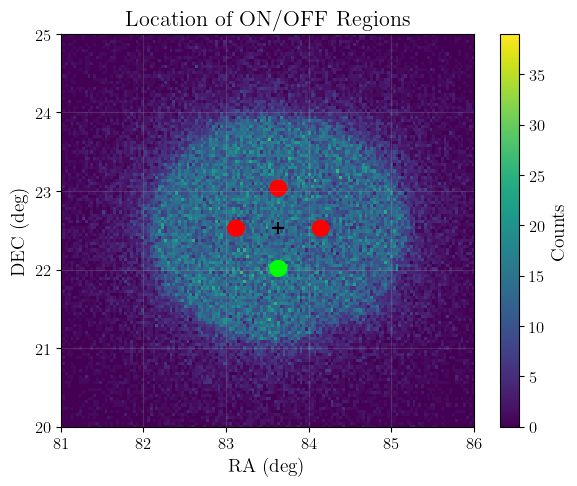

In [84]:
#assuming the variables RA_list, DEC_list, ras, decs, source_coords, etc. are already defined
fig, ax = plt.subplots(figsize=(6,5))

# Plot the 2D histogram
plt.hist2d(RA_list*180/np.pi, DEC_list*180/np.pi, bins=500, vmax=None)

# Plot scatter points
ax.scatter(ras, decs, marker='+', color='red')
ax.scatter(source_coords[0], source_coords[1], marker='+', color='lime')
ax.scatter(RA_pointing, DEC_pointing, marker='+', s=80, color='black')

# Add circles on top of the scatter plot and histogram
circ1 = plt.Circle(r1_coords, 0.1, color='red', fill=True, alpha=1)
circ2 = plt.Circle(r2_coords, 0.1, color='red', fill=True, alpha=1)
circ3 = plt.Circle(r3_coords, 0.1, color='red', fill=True, alpha=1)
circ4 = plt.Circle(source_coords, 0.1, color='lime', fill=True, alpha=1)

# Add the circles to the axes
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

# Labels and limits
ax.set_title("Location of ON/OFF Regions")
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

ax.set_xlim(81, 86)
ax.set_ylim(20, 25)

# ax.set_xlim(83.4,83.8)
# ax.set_ylim(21.5,22.25)

# Add grid
ax.grid(alpha=0.2)

# Colorbar (if needed)
cb = plt.colorbar()  # Uncomment this line if you want to display a colorbar
cb.set_label(label='Counts')

plt.savefig('plots/ON_OFF_pos_hist.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


#### Count the number of off events in each off region

In [21]:
#off events in first region
r1_events = sum_events(r1, RA_list, DEC_list)
print(r1_events)

321


In [22]:
#off events in second region
r2_events = sum_events(r2, RA_list, DEC_list)
print(r2_events)

309


In [23]:
#off events in third region
r3_events = sum_events(r3, RA_list, DEC_list)
print(r3_events)

348


In [24]:
print(f"The number of 'Off' events in each region are:\n" 
      f"Region 1: {r1_events} \n"
      f"Region 2: {r2_events} \n"
      f"Region 3: {r3_events} \n"
    )

The number of 'Off' events in each region are:
Region 1: 321 
Region 2: 309 
Region 3: 348 



### Applying significance formula

In [25]:
def significance(N_on, N_off, alpha):
    S = np.sqrt(2)*(

        (N_on * np.log( ((1+alpha)/alpha) * (N_on / (N_on + N_off)))) +
        
        (N_off * np.log( (1+alpha) * (N_off / (N_on + N_off)) ))
    
    )**(1/2)
    
    return S

#return and print significance, S, using N_off = \sum(all 3 background regions)
sig = significance(on_events, r1_events+r2_events+r3_events, 1/3)
print(
    f"Using the Li & Ma formulation of the maximum likelihood, \n" 
      f"the significance is {sig:.4f}"
      )

Using the Li & Ma formulation of the maximum likelihood, 
the significance is 10.1407


## Cut Optimization

In [98]:
#store mean scaled width and length in new variables
mscl_data = gammaray_data['mscl']
mscw_data = gammaray_data['mscw']

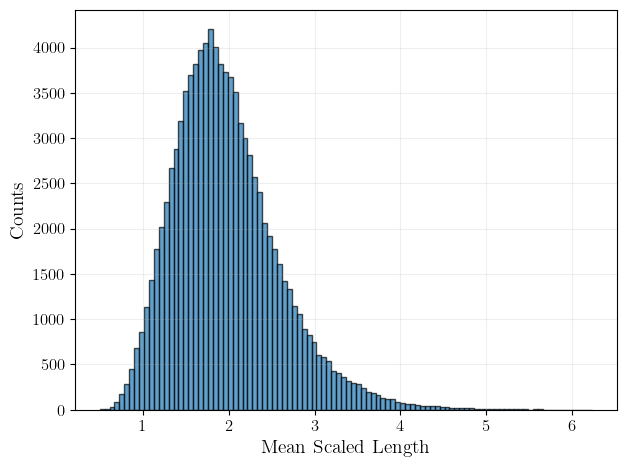

In [85]:
#histogram the mscl and mscw
fig = plt.hist(mscl_data, bins = 100, edgecolor='black', alpha=0.7)
plt.xlabel('Mean Scaled Length')
plt.ylabel("Counts")
plt.grid(alpha=0.2)
plt.savefig('plots/MSCL_hist.png', format='png', dpi=600, bbox_inches='tight')

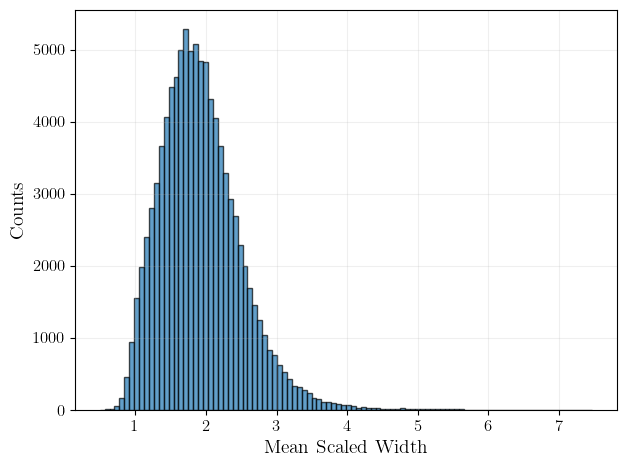

In [86]:
fig = plt.hist(mscw_data, bins = 100, edgecolor='black', alpha=0.7)
plt.xlabel('Mean Scaled Width')
plt.ylabel("Counts")
plt.grid(alpha=0.2)
plt.savefig('plots/MSCW_hist.png', format='png', dpi=600, bbox_inches='tight')

### Significance with MSCL & MSCW Cuts

To select the events that fall into certain mscl and mscw cut ranges, we first need a way of retrieving only the events that correspond to the predetermined cuts.

We can begin by creating a function that selects the indices of the events that fall into the desired cut ranges.

In [87]:
def select_cut_inds(mscl_data, cut_start, cut_size, n_cuts):
    """
    Returns the indices of events that fall into cut
    ranges of MSCW, MSCL: 0.9 -> 1.9 in steps of 0.1.
    """
    cut_inds = []
    new_cut = 0
    for i in range(n_cuts):
        cut = np.where((mscl_data > cut_start + new_cut) 
                       & (mscl_data <= (cut_start + cut_size + new_cut)))[0]
        cut_inds.append(cut)
        new_cut += cut_size
    return cut_inds

#### Retrieve cut indices

In [88]:
#retrieve the indices of events falling into cut ranges
cut_start=0.9
cut_size=0.1
n_cuts=10

mscl_cut_inds = select_cut_inds(mscl_data, cut_start=cut_start, cut_size=cut_size, n_cuts=n_cuts)
mscw_cut_inds = select_cut_inds(mscw_data, cut_start=cut_start, cut_size=cut_size, n_cuts=n_cuts)

#### Sanity checks

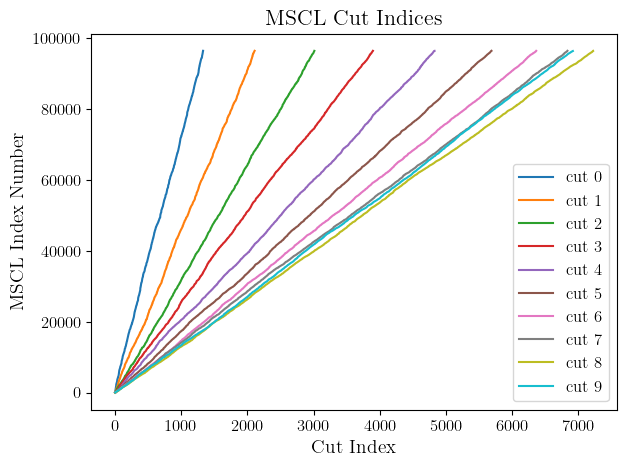

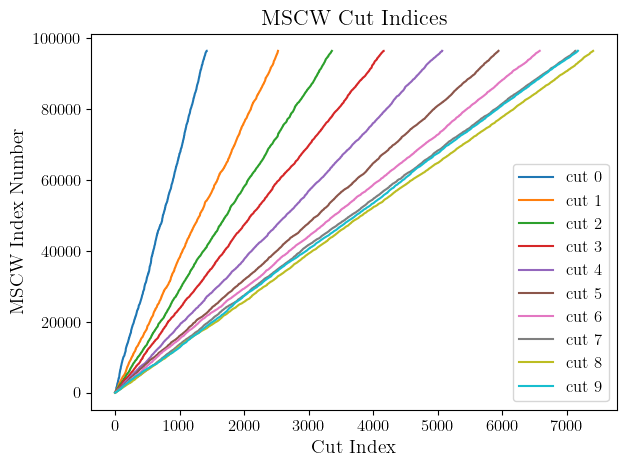

In [99]:

#peform a small sanity check to be sure that things worked correctly
for i in range(n_cuts):
    plt.title('MSCL Cut Indices')
    plt.plot(mscl_cut_inds[i], label = f"cut {i}")
    plt.ylabel('MSCL Index Number')
    plt.xlabel('Cut Index')
    plt.legend()

plt.savefig('plots/MSCL_cut_inds.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

for i in range(n_cuts):
    plt.title('MSCW Cut Indices')
    plt.plot(mscw_cut_inds[i], label = f"cut {i}")
    plt.ylabel('MSCW Index Number')
    plt.xlabel('Cut Index')
    plt.legend()

plt.savefig('plots/MSCW_cut_inds.png', format='png', dpi=600, bbox_inches='tight')


If things are working correctly, each cut should have a set of unique indices which is what the above plots are showing. We can also inspect things more explicitly.

In [92]:
#should return a bunch of empty lists if the cut_inds arrays are unique

print("printing tests for unique MSCL cut indices")
for i in range(n_cuts-1):
    common_elements = np.intersect1d(mscl_cut_inds[i], mscl_cut_inds[i+1])
    print(common_elements)

print("printing tests for unique MSCW cut indices")
for i in range(n_cuts-1):
    common_elements = np.intersect1d(mscw_cut_inds[i], mscw_cut_inds[i+1])
    print(common_elements)


printing tests for unique MSCL cut indices
[]
[]
[]
[]
[]
[]
[]
[]
[]
printing tests for unique MSCW cut indices
[]
[]
[]
[]
[]
[]
[]
[]
[]


#### Determine significance for each cut region

Begin by creating the function to populate the significance matrix for each MSCL and MSCW cut.

In [100]:
def cut_significance(
        mscl_cut_inds, 
        mscw_cut_inds,
        source_position,
        off1_position,
        off2_position, 
        off3_position,
        ras,
        decs,
        ):
    """
    Fill out the signifance heatmap (ie. determine the significance) 
    with MSCL along the y and MSCW along the x axis. 
    """
    
    S = np.zeros((len(mscl_cut_inds), len(mscl_cut_inds)))
    for i, mscl_cut in enumerate(mscl_cut_inds):
        print(f"computing mscl cut {i}")
        for j, mscw_cut in enumerate(mscw_cut_inds):
            total_cut_inds = list(set(mscl_cut) | set(mscw_cut))
            
            #calculate the number of on events per cut
            on_events = sum_events(source_position, ras[total_cut_inds], decs[total_cut_inds])

            #off events per cut (recalling off events are r1, r2, r3)
            r1_events = sum_events(off1_position, ras[total_cut_inds], decs[total_cut_inds])
            r2_events = sum_events(off2_position, ras[total_cut_inds], decs[total_cut_inds])
            r3_events = sum_events(off3_position, ras[total_cut_inds], decs[total_cut_inds])

            #want the sum of off events from each region
            off_events = r1_events + r2_events + r3_events

            #compute significance
            sig = significance(on_events, off_events, alpha=1/3)

            #fill out the significance 10x10 matrix
            S[i,j] = sig
    
    return S

In [94]:
#return the significance
cut_sig_mat = cut_significance(
    mscl_cut_inds, 
    mscw_cut_inds, 
    source_pos,
    r1,
    r2,
    r3,
    RA_list,
    DEC_list
    )

computing mscl cut 0
computing mscl cut 1
computing mscl cut 2
computing mscl cut 3
computing mscl cut 4
computing mscl cut 5
computing mscl cut 6
computing mscl cut 7
computing mscl cut 8
computing mscl cut 9


### Plot 2D Significance for each Cut Combination

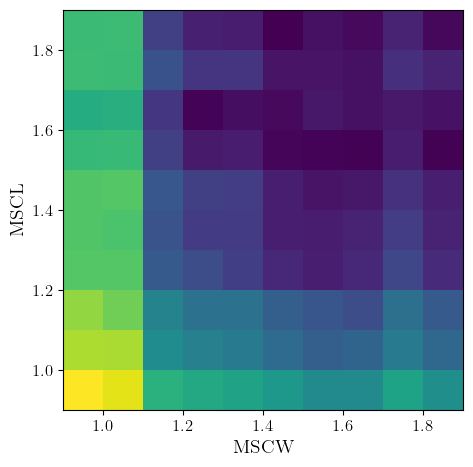

In [95]:
cut_sig_mat[np.isnan(cut_sig_mat)]=0
plt.imshow(
    cut_sig_mat, 
    origin='lower',
    extent=[cut_start, 
            cut_start + cut_size*n_cuts, 
            cut_start, 
            cut_start + cut_size*n_cuts]
    )
plt.xlabel('MSCW')
plt.ylabel('MSCL')
plt.savefig(f'plots/2d_sig_{cut_start}_{cut_size}_{n_cuts}.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

#### Determine optimal set of cuts from 2D significance matrix

In [96]:
#return the optimal indices for the 2D cut significance array
optimal_inds = np.unravel_index(np.argmax(cut_sig_mat), cut_sig_mat.shape)

#print the corresponding MSCW and MSCL values
print(
    f"The MSCL and MCSW values that produce the greatest significance are:\n"
    f"MSCL: cut {optimal_inds[0]} which corresponds to the range {cut_start + optimal_inds[0]*cut_size:.2f} - {cut_start + (optimal_inds[0]+1)*cut_size}  \n"
    f"MSCW: cut {optimal_inds[1]} which corresponds to the range {cut_start + optimal_inds[1]*cut_size:.2f} - {cut_start + (optimal_inds[1]+1)*cut_size}  \n"
    )

The MSCL and MCSW values that produce the greatest significance are:
MSCL: cut 0 which corresponds to the range 0.90 - 1.0  
MSCW: cut 0 which corresponds to the range 0.90 - 1.0  

